In [1]:
import create_Input_CNN
import init_train
import numpy as np
import train_model
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# We load the the data from our simulated dataset

In [2]:
file_x = '/scratch/rramabal/CNN_project_weeks/SelectomeCNN/chapter_3_DATA/training_file_Small.npy'
file_y = '/scratch/rramabal/CNN_project_weeks/SelectomeCNN/chapter_3_DATA/output_file_Small.npy'
file_label = '/scratch/rramabal/CNN_project_weeks/SelectomeCNN/chapter_3_DATA/name_training_file_Small.npy'

file_tx = '/scratch/rramabal/CNN_project_weeks/SelectomeCNN/chapter_3_DATA/testing_file_Small.npy'
file_ty = '/scratch/rramabal/CNN_project_weeks/SelectomeCNN/chapter_3_DATA/output_test_file_Small.npy'
file_tlabel = '/scratch/rramabal/CNN_project_weeks/SelectomeCNN/chapter_3_DATA/name_testing_file_Small.npy'

load_numpy = True

if load_numpy:
    Xt, Yt, Lt = init_train.load_data_numpy(file_x, file_y, file_label, file_tx, file_ty, file_tlabel, 123)
else:
    print("load_hdf")

# We split the data for training, validation and testing

In [3]:
new_len = int(len(Yt))

val_value = int(new_len*70/100)
test_value = int(new_len*20/100)

train_X = Xt[:val_value]
val_X = Xt[val_value:val_value+test_value]
test_X = Xt[val_value+test_value:]

train_Y = Yt[:val_value]
val_Y = Yt[val_value:val_value+test_value]
test_Y = Yt[val_value+test_value:]

train_L = Lt[:val_value]
val_L = Lt[val_value:val_value+test_value]
test_L = Lt[val_value+test_value:]

print("Training size: ", len(train_Y))
print("Validation size: ", len(val_Y))
print("Testing size: ", len(test_Y))

Training size:  880
Validation size:  251
Testing size:  127


# We create the datasets for training, validation and testing

In [4]:
BATCH_SIZE = 64

dataset_train = train_model.trainData(train_X, train_Y, train_L)
train_loader = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=False
)

dataset_val = train_model.trainData(val_X, val_Y, val_L)
val_loader = DataLoader(
    dataset_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

dataset_test = train_model.trainData(test_X, test_Y, test_L)
test_loader = DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False
)

# We init the network

In [5]:
#NUM_RAND_CNN = np.random.randint(91939434)
NUM_RAND_CNN = 68656248 #51131239 #68656248 #57832414
print(NUM_RAND_CNN)
torch.manual_seed(NUM_RAND_CNN)
NUMBER_FILTERS = 100
ROW_SIZE = 199
COL_SIZE = 396

model = train_model.coevClassifier_Separate(NUMBER_FILTERS, ROW_SIZE, COL_SIZE )

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)


68656248


In [6]:
model, loss_stats, accuracy_stats = train_model.train_network(6, train_loader, val_loader, model, criterion, optimizer)


Begin training.
Epoch 01: | Train Loss: 0.65922 | Val Loss: 0.56729 | Train Acc: 56.571| Val Acc: 75.000
Epoch 02: | Train Loss: 0.51444 | Val Loss: 0.41367 | Train Acc: 75.714| Val Acc: 83.000
Epoch 03: | Train Loss: 0.40623 | Val Loss: 0.28378 | Train Acc: 81.643| Val Acc: 88.000
Epoch 04: | Train Loss: 0.29375 | Val Loss: 0.20153 | Train Acc: 89.714| Val Acc: 94.000
Epoch 05: | Train Loss: 0.19217 | Val Loss: 0.13500 | Train Acc: 94.571| Val Acc: 96.000


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

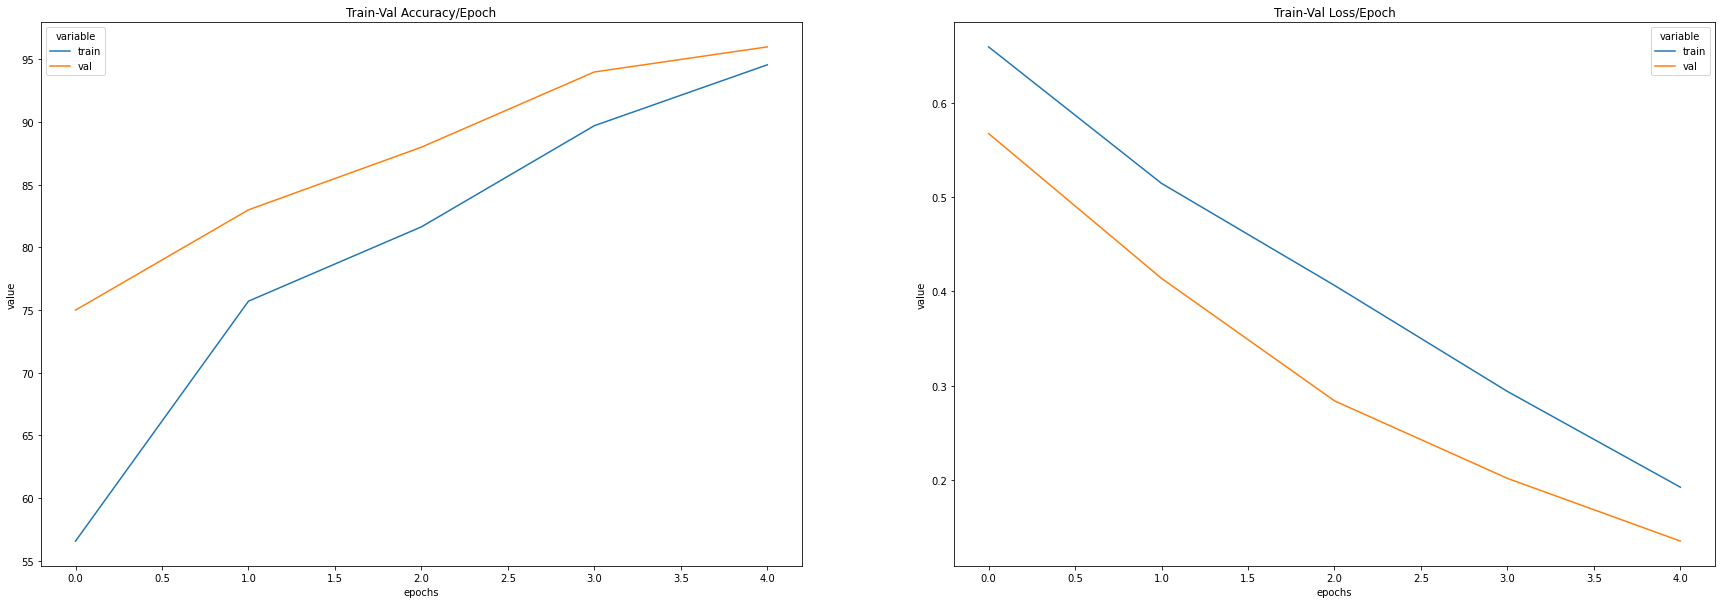

In [7]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [8]:
pred_list, true_list, name_list = train_model.test_model(model, test_loader)


In [18]:
ACC_SCORE = round(accuracy_score(true_list, pred_list),2)

print("Accuracy_score: ", ACC_SCORE)

Accuracy_score:  0.82


In [19]:
print(confusion_matrix(true_list, pred_list))

[[72  1]
 [22 32]]


In [20]:
torch.save(model.state_dict(), 'my_model.pt')

In [21]:
my_model = train_model.coevClassifier_Separate(NUMBER_FILTERS, ROW_SIZE, COL_SIZE )
my_model.load_state_dict(torch.load('my_model.pt'))
my_model.eval()

coevClassifier_Separate(
  (conv1): Conv2d(1, 100, kernel_size=(199, 1), stride=(1, 1))
  (conv2): Conv2d(100, 100, kernel_size=(1, 396), stride=(1, 1))
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc1_drop): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)

In [22]:
pred_list, true_list, name_list = train_model.test_model(my_model, test_loader)